---
title: "weight data"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---


Now that we have height data covered, it's time we deal with weight data.

Yes, I am **VERY WELL AWARE** that weight is a force, and it is not measured in kg. Nevertheless, I will use the word weight in the colloquial sense, and for all purposes it is a synonym for mass.

This analysis is based on the [CDC Growth Charts Data Files](https://www.cdc.gov/growthcharts/cdc-data-files.htm). From there I downloaded a csv for the weight of boys and girls, from age 2 to 20.

For each sex and age, the csv contains three important columns for us:

* $M$: median
* $S$: generalized coefficient of variation
* $L$: Box-Cox power

These three variables can be combined to give the weight W at a given Z-score (number of standard deviations from the mean):

$$
W = M \left(1 + L S Z\right)^{1/L}
\tag{1}
$$

The website contains a different formula for the case $L=0$, but in our data set $L$ is never zero.

It will be useful in a little while to know the inverse of Eq. (1), which is

$$
Z = \frac{(W/M)^L - 1}{L S}.
\tag{1b}
$$

The formulas above indicate that we're using the [Box-Cox distribution](https://en.wikipedia.org/wiki/Box%E2%80%93Cox_distribution) (also called power-normal distribution), and they will help us compute the probability density function (pdf) for weight. 

Given that the pdf of a z-scored variable is
$$
f_z(Z) = \frac{1}{\sqrt{2 \pi}} e^{-Z^2/2},
\tag{2}
$$

we need to change variables from Z to W. To do that, we will use

$$
f_w(W)dW = f_z(Z)dZ.
\tag{3}
$$

The rationale behind this is that the probability (area) of being in a small interval is the same, whether we measure it in terms of W or Z. See more here: [Function of random variables and change of variables in the probability density function](https://en.wikipedia.org/wiki/Probability_density_function#Scalar_to_scalar).
Solving Eq. (3) for $f_w(W)$, we get

$$
f_w(W) = f_z(Z) \left|\frac{dZ}{dW}\right| = f_z(Z) \left|\frac{dW}{dZ}\right|^{-1}.
\tag{4}
$$

Using Eq. (1), the derivative of $W$ with respect to $Z$ is

\begin{align*}
\frac{dW}{dZ} &= MS\left(1+LSZ\right)^{\frac{1}{L}-1}\\
              &= \underbrace{M\left(1+LSZ\right)^{\frac{1}{L}}}_{=W \text{ according to Eq. (1)}}S\left(1+LSZ\right)^{-1} \\
              &= WS\frac{1}{1+LSZ} \\
              &= WS\frac{1}{\bcancel{1}+\cancel{LS}\frac{(W/M)^L - \bcancel{1}}{\cancel{L S}}} \\
              &= WS\frac{1}{(W/M)^L} \\
              & = W^{1-L} M^L S
\tag{5}
\end{align*}

Putting everything together \[remember that we need the reciprocal of the result in Eq. (5)\], we get

\begin{align*}
f_w(W) &= f_z(Z) \frac{W^{L-1}}{M^L S} \\
       &= \frac{1}{\sqrt{2 \pi}} e^{-Z^2/2} \frac{W^{L-1}}{M^L S}
\tag{6}
\end{align*}

Of course, we could have substituted $Z$ from Eq. (1b) into Eq. (6) to get a formula that depends only on $W$, it would be too messy. Later on, we will compute $f_w(W)$ numerically, so we will not need to do that.

## example

Let's see the weight probability density for boys at age 10 and 15.

In [26]:
#| code-summary: "import libraries"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", font_scale=1.5)
from scipy.stats import powernorm

In [44]:
#| code-summary: "load weight data and compute pdf"
weight_list = np.arange(10, 130, 0.1)
def power_normal_pdf(w, age, sex):
    """
    Calculates the PDF of the Power Normal distribution from the derived formula.
    This function correctly handles negative L values.
    """
    # This function is only valid for w > 0
    w = np.asarray(w)
    pdf = np.full(w.shape, np.nan)
    positive_w = w[w > 0]
    df = pd.read_csv('../archive/data/weight/wtage.csv')
    agemos = age * 12 + 0.5
    df = df[(df['Agemos'] == agemos) & (df['Sex'] == sex)]
    L = df['L'].values[0]
    M = df['M'].values[0]
    S = df['S'].values[0]
    
    # Calculate the z-score
    z = ((positive_w / M)**L - 1) / (L * S)
    
    # Calculate the two main parts of the formula
    pre_factor = positive_w**(L - 1) / (S * M**L * np.sqrt(2 * np.pi))
    exp_term = np.exp(-0.5 * z**2)
    
    # Store the results only for the valid (positive w) indices
    pdf[w > 0] = pre_factor * exp_term
    return pdf

pdf_boys10 = power_normal_pdf(weight_list, 10, 1)
pdf_boys15 = power_normal_pdf(weight_list, 15, 1)

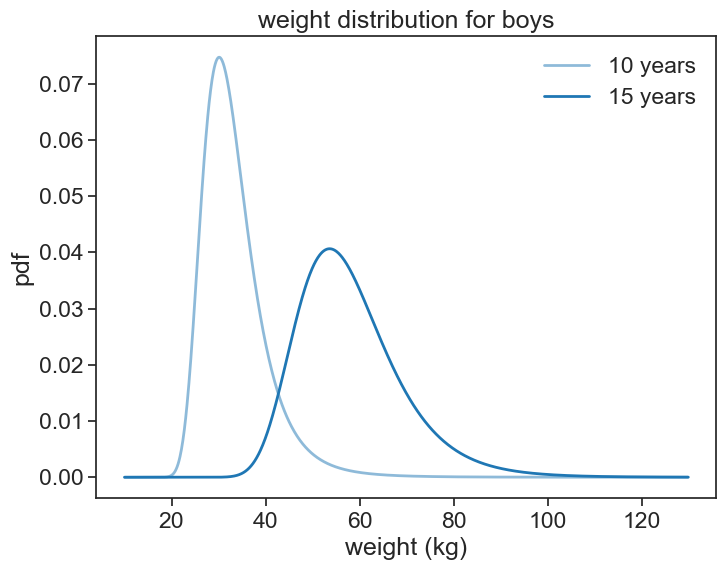

In [45]:
#| code-summary: "plot"
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(weight_list, pdf_boys10, color='tab:blue', lw=2, alpha=0.5, label='10 years')
ax.plot(weight_list, pdf_boys15, color='tab:blue', lw=2, label='15 years')
ax.set(xlabel='weight (kg)',
       ylabel='pdf',
       title="weight distribution for boys")
ax.legend(loc="upper right", frameon=False)

In future chapters, when we want to talk about weight, it will be more convenient to leverage scipy's capabilities, both to compute the pdf and to generate random samples.

In [57]:
#| code-summary: "leveraging scipy.stats"
def scipy_power_normal_pdf(w, age, sex):
    
    # Load LMS parameters from the CSV file
    df = pd.read_csv('../archive/data/weight/wtage.csv')
    agemos = age * 12 + 0.5
    df = df[(df['Agemos'] == agemos) & (df['Sex'] == sex)]
    L = df['L'].values[0]
    M = df['M'].values[0]
    S = df['S'].values[0]
    
    # 1. Transform weight (w) to the standard normal z-score
    z = ((w / M)**L - 1) / (L * S)
    
    # 2. Calculate the derivative of the transformation (dz/dw)
    # This is the Jacobian factor for the change of variables
    dz_dw = (w**(L - 1)) / (S * M**L)
    
    # 3. Apply the change of variables formula: pdf(w) = pdf(z) * |dz/dw|
    pdf = stats.norm.pdf(z) * dz_dw
    
    return pdf

def scipy_power_normal_draw_random(N, age, sex):   
    # Load LMS parameters from the CSV file
    df = pd.read_csv('../archive/data/weight/wtage.csv')
    agemos = age * 12 + 0.5
    df = df[(df['Agemos'] == agemos) & (df['Sex'] == sex)]
    L = df['L'].values[0]
    M = df['M'].values[0]
    S = df['S'].values[0]

    # draw random z from standard normal distribution
    z = np.random.normal(0, 1, N)
    # transform z to w
    w = M * (1 + L * S * z)**(1 / L)
    
    return w

# Calculate the PDFs for 10 and 15-year-old boys using the SciPy-based function
scipy_pdf_boys10 = scipy_power_normal_pdf(weight_list, 10, 1)
draw10 = scipy_power_normal_draw_random(1000, 10, 1)
scipy_pdf_boys15 = scipy_power_normal_pdf(weight_list, 15, 1)

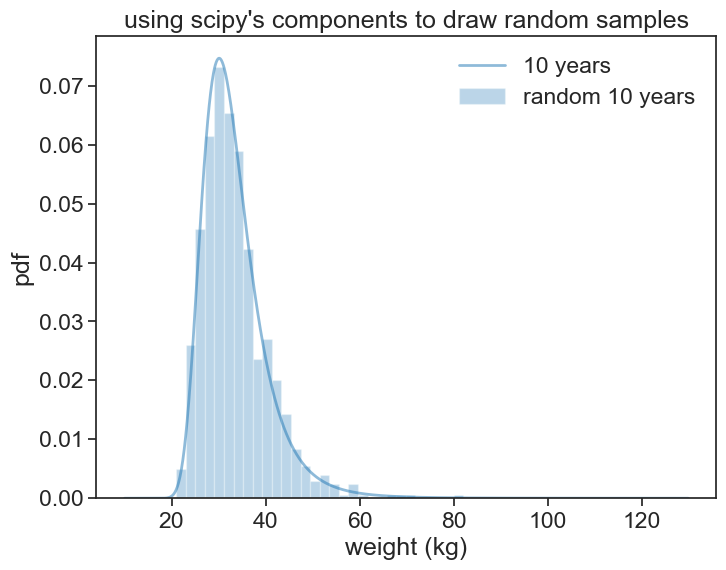

In [59]:
#| code-summary: "plot"
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(weight_list, pdf_boys10, color='tab:blue', lw=2, alpha=0.5, label='10 years')
# histogram of draw10
ax.hist(draw10, bins=30, density=True, color='tab:blue', alpha=0.3, label='random 10 years')
# ax.plot(weight_list, scipy_pdf_boys10, color='tab:blue', ls=":", label='scipy 10')
ax.set(xlabel='weight (kg)',
       ylabel='pdf',
       title="using scipy's components to draw random samples")
ax.legend(loc="upper right", frameon=False)